In [12]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix


In [2]:
# Load the datasets
fraud_data = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/ML/SnappBOX/data/part2-fraud-sample.csv')
dataset = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/ML/SnappBOX/data/part2-dataset.csv')

/var/folders/mx/8hc3c2316511q43kfytnj1kw0000gn/T/ipykernel_67016/1142555060.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('/Users/shahriyar/Desktop/programming/Python/ML/SnappBOX/data/part2-dataset.csv')


In [3]:
dataset.head()

,Unnamed: 0,created_date,customer_id,biker_request_id,biker_phone_number,order_request_id,city,delivery_category_id,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude
0,0,2023-08-03,11653225,1305684.0,f0xsz+2AwzyE5upJoZiRPg==,476979798,mashhad,2,d0584bd9-3faf-4548-9524-2301c6b53477,DELIVERED,110000.0,IJ/G/FCku4VmMc0ysmeljQ==,27.182306,21.339714,21.335510,27.184477
1,1,2023-08-03,11653225,17520.0,HhcTOAXS3fjGB8qV56pvsA==,473276458,mashhad,2,f88d3cc4-c855-4f64-8d68-76d169c1f208,DELIVERED,180000.0,bcTH3WaJCXBpue89a8nY/Q==,27.346241,21.374972,21.372564,27.347296
2,2,2023-08-03,11653225,2642406.0,MsBIgqhcHug2ABwrs/NpBw==,475854199,mashhad,2,a5d029ea-fb97-4617-9d65-cb921f535564,DELIVERED,40000.0,Zu0mYA6iyC/YKiweS93tqg==,27.184062,21.331320,21.331901,27.183952
3,3,2023-08-03,11653225,2909573.0,sMFPNzhcZLFq5qUlA6hkYg==,477350228,mashhad,2,b4d252eb-1b73-4094-a54f-612cb8c87eda,DELIVERED,345000.0,0qabDebg/QgYtAdbErDsgw==,27.345351,21.376528,21.376674,27.350910
4,4,2023-08-03,11653225,2285206.0,rPKRNUD0f0ivPb5PIxIVNw==,476319552,mashhad,2,7eb32010-e262-4b93-bd4f-4ca6008ea60d,DELIVERED,420000.0,0qabDebg/QgYtAdbErDsgw==,27.383733,21.349205,21.346586,27.385021


In [4]:
fraud_data.head()

,Unnamed: 0,created_date,customer_id,reason,biker_request_id,biker_phone_number,order_request_id,city,delivery_category,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude
0,92,2023-08-03,2,same_biker_same_customer,2997747,DdYkRZO6s/7+wAqt/ykX4Q==,476519902,mashhad,big-box,424438625,DELIVERED,162500.000000,DdYkRZO6s/7+wAqt/ykX4Q==,27.374180,21.347616,21.347160,27.368386
1,478,2023-08-08,11653225,fake ride,2948946,ELJeQx5rxhhEmfHwgA5OYw==,477901383,mashhad,bike-without-box,9587ae55-7fe6-4ce3-a3d3-5318aea99f5b,DELIVERED,180000.000000,fAhijISaQLNNfvt2Epm7Lw==,27.372249,21.363878,21.363502,27.372126
2,328,2023-08-06,14109185,fake ride,2996281,Ye3KL4SuOSsObrqLQEpzmw==,472410620,mashhad,bike-without-box,13783376,DELIVERED,413333.333333,ql+OWn4d094Dv+qGekHDyg==,27.366596,21.353237,21.353792,27.366384
3,218,2023-08-05,11653225,fake ride,2007528,F9W4mmmFG3vs3WYeRlmx8g==,472812665,mashhad,bike-without-box,42d55f08-068f-43d4-87e5-a61b21277dc3,DELIVERED,80000.000000,qZTnfP8YOg40wBZ2DnB57w==,27.368057,21.351640,21.351580,27.368103
4,387,2023-08-07,11653225,fake ride,3209726,s1FugjWvloZA+ZftOJmFJQ==,475974765,mashhad,bike-without-box,98450165-3f2c-4dc2-833e-eda0d2f02edd,DELIVERED,160000.000000,6xiri9b2vdfrbLxkZLkIZw==,27.367335,21.364569,21.364643,27.367372


In [5]:
fraud_reasons = ['fake ride', 'same_biker_same_customer']

# Find out all unique combinations of customer_id and biker_request_id that are fraudulent
fraudulent_combinations = fraud_data[fraud_data['reason'].isin(fraud_reasons)][['customer_id', 'biker_request_id']]

# Create the is_fraud column, default to False
dataset['is_fraud'] = False

# Now, we need to update this column in the dataset based on the fraudulent_combinations
for index, row in fraudulent_combinations.iterrows():
    dataset.loc[
        (dataset['customer_id'] == row['customer_id']) & 
        (dataset['biker_request_id'] == row['biker_request_id']), 
        'is_fraud'
    ] = True

# Save the dataset with the new 'is_fraud' column to a new CSV
dataset.to_csv('part2-dataset-with-is_fraud.csv', index=False)

In [6]:
new_dataset=pd.read_csv('part2-dataset-with-is_fraud.csv')

/var/folders/mx/8hc3c2316511q43kfytnj1kw0000gn/T/ipykernel_67016/704785773.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  new_dataset=pd.read_csv('part2-dataset-with-is_fraud.csv')


In [7]:
new_dataset.head()

,Unnamed: 0,created_date,customer_id,biker_request_id,biker_phone_number,order_request_id,city,delivery_category_id,customer_ref_id,final_status,biker_fare_per_terminal,customer_phone_number,destination_longitude,destination_latitude,source_latitude,source_longitude,is_fraud
0,0,2023-08-03,11653225,1305684.0,f0xsz+2AwzyE5upJoZiRPg==,476979798,mashhad,2,d0584bd9-3faf-4548-9524-2301c6b53477,DELIVERED,110000.0,IJ/G/FCku4VmMc0ysmeljQ==,27.182306,21.339714,21.335510,27.184477,False
1,1,2023-08-03,11653225,17520.0,HhcTOAXS3fjGB8qV56pvsA==,473276458,mashhad,2,f88d3cc4-c855-4f64-8d68-76d169c1f208,DELIVERED,180000.0,bcTH3WaJCXBpue89a8nY/Q==,27.346241,21.374972,21.372564,27.347296,True
2,2,2023-08-03,11653225,2642406.0,MsBIgqhcHug2ABwrs/NpBw==,475854199,mashhad,2,a5d029ea-fb97-4617-9d65-cb921f535564,DELIVERED,40000.0,Zu0mYA6iyC/YKiweS93tqg==,27.184062,21.331320,21.331901,27.183952,False
3,3,2023-08-03,11653225,2909573.0,sMFPNzhcZLFq5qUlA6hkYg==,477350228,mashhad,2,b4d252eb-1b73-4094-a54f-612cb8c87eda,DELIVERED,345000.0,0qabDebg/QgYtAdbErDsgw==,27.345351,21.376528,21.376674,27.350910,False
4,4,2023-08-03,11653225,2285206.0,rPKRNUD0f0ivPb5PIxIVNw==,476319552,mashhad,2,7eb32010-e262-4b93-bd4f-4ca6008ea60d,DELIVERED,420000.0,0qabDebg/QgYtAdbErDsgw==,27.383733,21.349205,21.346586,27.385021,False


In [8]:
print(new_dataset.isnull().sum())

Unnamed: 0                    0
created_date                  0
customer_id                   0
biker_request_id           1224
biker_phone_number         1224
order_request_id              0
city                          0
delivery_category_id          0
customer_ref_id               0
final_status                  0
biker_fare_per_terminal       0
customer_phone_number         0
destination_longitude         0
destination_latitude          0
source_latitude               0
source_longitude              0
is_fraud                      0
dtype: int64


In [9]:
new_dataset = new_dataset.dropna()
new_dataset = new_dataset.drop_duplicates()
print(new_dataset.isnull().sum())

Unnamed: 0                 0
created_date               0
customer_id                0
biker_request_id           0
biker_phone_number         0
order_request_id           0
city                       0
delivery_category_id       0
customer_ref_id            0
final_status               0
biker_fare_per_terminal    0
customer_phone_number      0
destination_longitude      0
destination_latitude       0
source_latitude            0
source_longitude           0
is_fraud                   0
dtype: int64


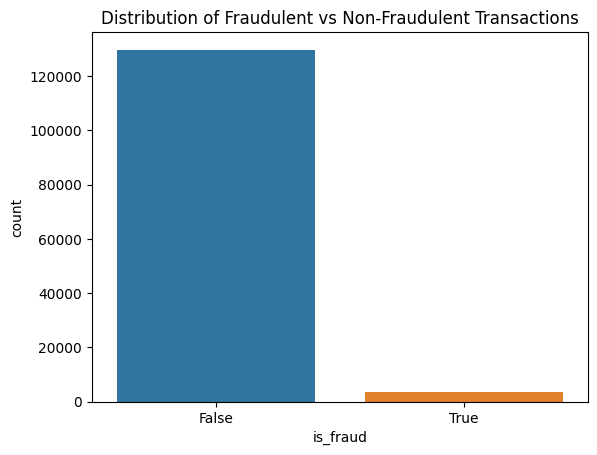

In [10]:
sns.countplot(x='is_fraud', data=new_dataset)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

/var/folders/mx/8hc3c2316511q43kfytnj1kw0000gn/T/ipykernel_67016/2291998791.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


[[21484  4728]
 [  162   499]]
              precision    recall  f1-score   support

       False       0.99      0.82      0.90     26212
        True       0.10      0.75      0.17       661

    accuracy                           0.82     26873
   macro avg       0.54      0.79      0.53     26873
weighted avg       0.97      0.82      0.88     26873

ROC AUC Score: 0.7872706960791941


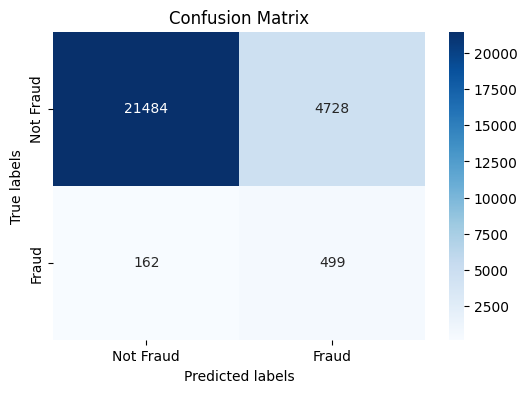

In [14]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess the dataset
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    columns_to_drop = ['Unnamed: 0', 'created_date', 'customer_id', 'biker_request_id', 
                       'biker_phone_number', 'order_request_id', 'customer_ref_id', 'customer_phone_number','city','final_status']
    df.drop(columns=columns_to_drop, inplace=True)

    return df

# Function to normalize features
def normalize_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# Function to split the data
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Function to balance data using SMOTE
def balance_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

# Function to train the model
def train_model(X_train, y_train):
    gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_classifier.fit(X_train, y_train)
    return gb_classifier

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    print(classification_report(y_test, predictions))
    print(f"ROC AUC Score: {roc_auc_score(y_test, predictions)}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Main execution function
def main():
    # Load and preprocess the data
    df = load_and_preprocess_data('part2-dataset-with-is_fraud.csv')

    # Separate the features and the target variable
    X = df.drop('is_fraud', axis=1)
    y = df['is_fraud']

    # Normalize the features
    X_scaled, scaler = normalize_features(X)

    # Split the data
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)

    # Balance the training dataset using SMOTE
    X_train_smote, y_train_smote = balance_data(X_train, y_train)

    # Train the model
    model = train_model(X_train_smote, y_train_smote)

    # Evaluate the model
    evaluate_model(model, X_test, y_test)

# Run the main function
if __name__ == "__main__":
    main()